In [1]:
import scanpy as sc
import matplotlib.pyplot as pl
import seaborn as sns
import pandas as pd
import numpy as np
import sys
from pathlib import Path

# Paths and utils
root = Path('../')
figure_path = root / 'results/figures/Neutrophils/'
figure_path.mkdir(parents=True, exist_ok=True)
table_path = root / 'results/tables/'
data_path = root / 'data/'
signatures_path = root / 'resources/'
# local utils
sys.path.insert(1, '../utils/')
from utils import rsum, run_progeny, score_hallmarks

# Set plotting style
from matplotlib import rcParams
# Type 2/TrueType fonts
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
# Arial font
rcParams['font.sans-serif'] = "Arial"
rcParams['font.family'] = "sans-serif"
%matplotlib inline

# Prepare hamster data for analysis

In [2]:
superdata = sc.read(data_path / "Cov19Hamster_timecourse_integrated_all.h5")

# convenience obs annotations
superdata.obs['SCoV2_detected'] = superdata.obs['SCoV2_sum'] > 0
superdata.obs['organism_time'] = [o+'_'+t for o, t in zip(superdata.obs['organism'], superdata.obs['time'])]
superdata.obs['organism_dosage'] = [o+'_'+d for o, d in zip(superdata.obs['organism'], superdata.obs['dosage'])]
superdata.obs['organism_dosage_time'] = [o+'_'+d+'_'+t for o, d, t in zip(superdata.obs['organism'], superdata.obs['dosage'], superdata.obs['time'])]
superdata.obs['time_num'] = [int(x[1:]) for x in superdata.obs.time]
times = pd.unique(superdata.obs['time_num'])
time_dict = dict(zip(times, np.arange(len(times))))
superdata.obs['time_order'] = [time_dict[x] for x in superdata.obs.time_num]
superdata.obs['replicate'] = [x[2] for x in superdata.obs.hamster]

In [3]:
# filter genes to be expressed in at least a few cells and have at least a few counts in total
limit_cells = (rsum(superdata.layers['counts']>0, axis=0) > 20)
limit_counts = rsum(superdata.layers['counts'], axis=0) > 100
superdata = superdata[:, limit_cells & limit_counts].copy()
print('AnnData shape:', superdata.shape)

AnnData shape: (84794, 19558)


In [4]:
# scoring
run_progeny(superdata, 'mouse')
score_hallmarks(superdata, 'all', species='mouse', signatures_path=signatures_path)

# define control dicts for DE testing etc.
control_dict = {x: ['pr_D0_Z1_L','pr_D0_Z2_L','pr_D0_Z3_L'] if 'pr' in x else ['ma_d0_lung_1', 'ma_d0_lung_2', 'ma_d0_lung_3'] for x in pd.unique(superdata.obs['orig.ident']) if '0' not in x}
control_dict_odt = {x: 'Dwarfhamster_no dose_D0' if 'Dwarfhamster' in x else 'Goldhamster_no dose_D0' for x in superdata.obs.organism_dosage_time.unique() if 'D0' not in x}

Running mlm on mat with 84794 samples and 19558 targets for 14 sources.


100%|██████████| 10/10 [00:11<00:00,  1.19s/it]


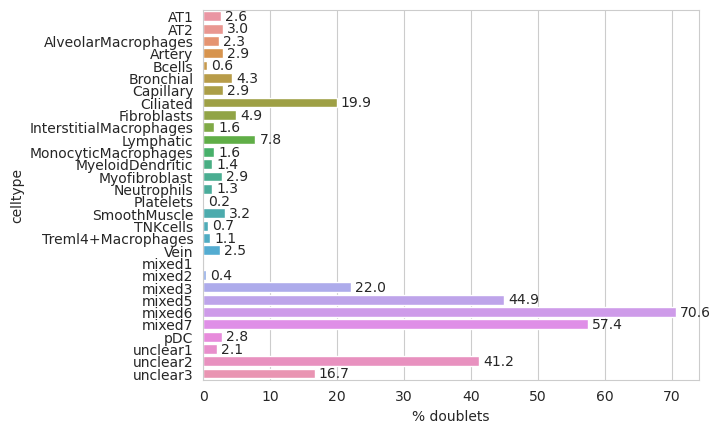

In [ ]:
X = superdata.obs.value_counts(['celltype', 'scrub_doublets'], sort=False, normalize=False)
Y = 100*X.loc[:, 1] / (X.loc[:, 0] + X.loc[:, 1])
with sns.axes_style('whitegrid'):
    ax = sns.barplot(data=Y.reset_index(), y='celltype', x=0)
    ax.bar_label(ax.containers[0], fmt='%0.1f', padding=3)
pl.xlabel('% doublets')
pl.show()

In [6]:
# Remove doublet clusters and rename cleared singlet clusters
clear_dict = {
    'unclear1': 'NK cells',  # singlets
    'unclear2': 'Neutrophils',  # likely a mix of Neutros and Neutro-Neutro doublets
    'unclear3': 'Platelets',  # lies directly next to Platelet cluster, many doublets
    'mixed1': 'ILC2',
    'mixed2': 'Neutrophils',  # not doublets, are Neutros
    'mixed3': None,  # Confirmed B-cell + Neutro doublets
    # there is no mixed4
    'mixed5': 'AT2',  # contains 45% doublets!
    'mixed6': None,  # Confirmed B-cell + T-cell doublets
    'mixed7': None,  # unidentified doublets
    'MyeloidDendritic': 'cDC',  # cDC is more recent nomenclature
}
superdata.obs['celltype'] = superdata.obs['celltype'].replace(clear_dict).astype(str)
superdata = superdata[superdata.obs.celltype!='None'].copy()
 

In [7]:
# Reassign some cell types
# 24 are Plasma cells (Jchain, Mzb1)
# 29 are Mast cells (Cpa3, Mrgprx2, Ms4a2)
# 27 are Erythocytes (Alas2, HBB, HBA)
# 33 unknown, not doublets
# 23 confirmed pDCs (IRF8, PLD4)
# 32 unknown, not doublets
# 25 confirmed cDCs (IRF8)
# 20 confirmed platelets (PF4, Ppbp)
# 30 confirmed Endos (CCL21, Gng11, Mmrn1)
# might want to reorder some clusters?
reass_dict = {
    # reidentified clusters
    '24': 'Plasma cells',  # (Jchain, Mzb1)
    '29': 'Mast cells',  # (Cpa3, Mrgprx2, Ms4a2)
    '27': 'Erythrocytes'  # (Alas2, Hbb, Hba)
}
superdata.obs.celltype = superdata.obs.celltype.astype(str)
for k, v in reass_dict.items():
    superdata.obs.loc[superdata.obs['louvain_scVI']==k, 'celltype'] = v

In [8]:
# Additionally, remove singular doublets
superdata = superdata[superdata.obs.scrub_doublets==0].copy() 

In [9]:
# reannotate TNK cells
celltype_df = pd.read_csv('../resources/TNK_reannotation.csv', index_col=0)
celltype_df = celltype_df[np.isin(celltype_df.index, superdata.obs_names)]
superdata.obs.loc[celltype_df.index, 'celltype'] = celltype_df['celltype_']
superdata = superdata[superdata.obs.celltype!='doublets'].copy()
superdata = superdata[superdata.obs.celltype!='TNK cells'].copy()

In [10]:
# Mapping fine cell type annotation to a more coarse ("rough") one
rough_dict = {
    # Endos
    'Capillary': 'Endothelial cells',
    'Vein': 'Endothelial cells',
    'Artery': 'Endothelial cells',
    'Bronchial': 'Endothelial cells',
    'Lymphatic': 'Endothelial cells',
    
    # Macros
    'Treml4+Macrophages': 'Macrophages',
    'MonocyticMacrophages': 'Macrophages',
    'InterstitialMacrophages': 'Macrophages',
    'AlveolarMacrophages': 'Macrophages',
    
    # T and NK
    'activated T cells': 'T cells',
    'CD8+ T cells': 'T cells',
    'CD4+ T cells': 'T cells',
    'NKT cells': 'NK cells', # closer to NK than T cells
    
    # Epis
    'AT1': 'Epithelial cells',
    'AT2': 'Epithelial cells',
    'Ciliated': 'Epithelial cells',
}

superdata.obs['celltype_rough'] = superdata.obs['celltype'].replace(rough_dict).astype(str)

In [11]:
# Import color options
import yaml
with open('../config/config.yaml', 'r') as file:
    config = yaml.safe_load(file)
celltype_colors = config['celltype_colors']
celltype_rough_colors = config['celltype_rough_colors']
organism_colors = config['organism_colors']
organism_dosage_colors = config['organism_dosage_colors']
dosage_colors = config['dosage_colors']

from matplotlib.cm import get_cmap
# not super pretty, but ok for now
time_colors = {
    'D0': 'grey',
    'D2': get_cmap('viridis_r')(0),
    'D3': get_cmap('viridis_r')(1/3),
    'D5': get_cmap('viridis_r')(2/3),
    'E14': get_cmap('viridis_r')(1),
              }

# hier passt was ned
superdata.uns['celltype_colors'] = np.array(list(dict(sorted(celltype_colors.items())).values()))
superdata.uns['celltype_rough_colors'] = np.array(list(dict(sorted(celltype_rough_colors.items())).values()))
superdata.uns['organism_colors'] = np.array(list(dict(sorted(organism_colors.items())).values()))
superdata.uns['organism_dosage_colors'] = np.array(list(dict(sorted(organism_dosage_colors.items())).values()))
superdata.uns['dosage_colors'] = np.array(list(dict(sorted(dosage_colors.items())).values()))

In [12]:
# Newer names, more accurate
organism_rename_dict = {
    'Dwarfhamster': 'Roborovski hamster',
    'Goldhamster': 'Syrian hamster'
}
time_rename_dict = {
    'D0': '0 dpi',
    'D2': '2 dpi',
    'D3': '3 dpi',
    'D5': '5 dpi',
    'E14': '14 dpi'
}
dosage_rename_dict = {
    'no dose': '0 pfu',
    'low dose': r'1x10$^4$ pfu',
    'high dose': r'1x10$^5$ pfu'
}

def sanitize_name(s):
    for rdict in [organism_rename_dict, time_rename_dict, dosage_rename_dict]:
        for old, new in rdict.items():
            s = s.replace(old, new)
    return s.replace('_', ', ')

# Capitalized obs keys are "sanitized" ones (i.e. mapped to new names)
for key in ['dosage', 'time', 'organism', 'organism_dosage', 'organism_dosage_time', 'organism_time']:
    superdata.obs['_'.join([x.capitalize() for x in key.split('_')])] = [sanitize_name(s) for s in superdata.obs[key]]
    
# Translate color palettes to new names as well
Organism_colors = {sanitize_name(key) : value for key, value in config['organism_colors'].items()}
Organism_Dosage_colors = {sanitize_name(key) : value for key, value in config['organism_dosage_colors'].items()}
Dosage_colors = {sanitize_name(key) : value for key, value in config['dosage_colors'].items()}
Time_colors = {sanitize_name(key) : value for key, value in time_colors.items()}

superdata.uns['Organism_colors'] = np.array(list(dict(sorted(Organism_colors.items())).values()))
superdata.uns['Organism_Dosage_colors'] = np.array(list(dict(sorted(Organism_Dosage_colors.items())).values()))
superdata.uns['Dosage_colors'] = np.array(list(dict(sorted(Dosage_colors.items())).values()))

In [13]:
# cached write to disk
cached = data_path / "Pancov19_prepd_all.h5"
superdata.write(cached)

# Merge Metadata (.obs) of Multiple Datasets for easy access

In [26]:
# load data
MelmsIzar290421_data = sc.read(data_path / "MelmsIzar290421_data.h5")  # severity annotation was wrongly processes! We do have control samples.
LiaoZhang120520_data = sc.read(data_path / "LiaoZhang120520_data.h5")
ChuaEils290620_data = sc.read(data_path / "ChuaEils290620_data.h5")
WendischSander241022_data = sc.read(data_path / "WendischSander241022_data.h5")
Hamster_data = sc.read(data_path / "Pancov19_prepd_all.h5")
MelmsIzar290421_data.obs.severity = ['control' if s=='healthy' else 'critical' for s in MelmsIzar290421_data.obs.disease]  # correction of severity annotation

# Process metadata, add handles for convenience
Hamster_data.obs['sample_id'] = Hamster_data.obs['orig.ident'].copy()
Hamster_data.obs['temp'] = [f'{o}_healthy' if t=='D0' else f'{o}_recovered' if t=='E14' else f'{o}_infected' for t, o in zip(Hamster_data.obs.time, Hamster_data.obs.organism)]
ChuaEils290620_data.obs['sample_type_id'] = ChuaEils290620_data.obs.sample_type.map({
    'BALF': 'BALF', 'Nasal Swap': 'NS', 'Protected Specimen Brush': 'PSB'})
ChuaEils290620_data.obs['temp'] = [f'Chua_{z}_{s}' for z, s in zip(ChuaEils290620_data.obs.sample_type_id, ChuaEils290620_data.obs.severity)]
LiaoZhang120520_data.obs.severity =LiaoZhang120520_data.obs.severity.astype(str)
LiaoZhang120520_data.obs.severity[LiaoZhang120520_data.obs.severity=='nan'] = 'control'
LiaoZhang120520_data.obs['temp'] = [f'Liao_{s}' for s in LiaoZhang120520_data.obs.severity]
MelmsIzar290421_data.obs['temp'] = [f'Melms_{s}' for s in MelmsIzar290421_data.obs.severity]
WendischSander241022_data.obs['temp'] = [f'Wendisch_{s}' for s in WendischSander241022_data.obs.severity]

Hamster_data.obs['dataset'] = Hamster_data.obs['organism']
LiaoZhang120520_data.obs['dataset'] = 'Liao'
ChuaEils290620_data.obs['dataset'] = 'Chua'
MelmsIzar290421_data.obs['dataset'] = 'Melms'
WendischSander241022_data.obs['dataset'] = 'Wendisch'

# aggregate all dataset-wise metadata into one gigantic dataframe (over half a gigabyte, wow!)
df = pd.concat([Hamster_data.obs, ChuaEils290620_data.obs, LiaoZhang120520_data.obs, MelmsIzar290421_data.obs, WendischSander241022_data.obs], axis=0)

# unify celltype annotations
df['celltype'] = df['celltype'].astype(str)
for ct in ['Bronchial', 'Capillary', 'Artery', 'Vein', 'Lymphatic']:
    df['celltype'][df['celltype']==ct] = 'Endothelial cells'
for ct in ['InterstitialMacrophages', 'MonocyticMacrophages', 'Treml4+Macrophages', 'AlveolarMacrophages', 'Monocytes']:
    df['celltype'][df['celltype']==ct] = 'Macrophages'
for ct in ['Tuft-like', 'Ciliated', 'Epithelial', 'AT1', 'AT2']:
    df['celltype'][df['celltype']==ct] = 'Epithelial cells'
for ct in ['pDC', 'MyeloidDendritic', 'cDC', 'mDC']:
    df['celltype'][df['celltype']==ct] = 'DCs'
for ct in ['activated T cells', 'CD4+ T cells', 'CD8+ T cells', 'NK cells', 'NKT cells']:
    df['celltype'][df['celltype']==ct] = 'TNKcells'
# Only keep the most important celltypes, rest is henceforth called "Other"
df['celltype'][~df.celltype.isin(['Epithelial cells', 'Bcells', 'TNKcells', 'DCs', 'Macrophages', 'Neutrophils', 'Endothelial cells'])] = 'Other'

# save to disk for later use (to data_path, too large for github)
df.to_csv(data_path / "joint_metadata.csv")

# Merge tables for supplement (run this after analysis is done)

In [ ]:
table_path = Path('../results/tables/')

In [19]:
# Table1 + DESEQ2
writer = pd.ExcelWriter(table_path / "Supplemental Table 1.xlsx", engine="xlsxwriter")

for file in table_path.iterdir():
    if 'Fig1' in file.name and 'source' in file.name:
        df = pd.read_csv(file, index_col=0)
        df.to_excel(writer, sheet_name=file.name.split('.')[0][:31])

dpath = Path('../results/DESeq2/infection/')
tabs = {file.name.split('.')[0]: pd.read_csv(file, index_col=0) for file in dpath.iterdir() if file.suffix=='.csv'}
for key, df in tabs.items():
    df.to_excel(writer, sheet_name=('DESEQ2_'+key.replace('_COVID19_vs_healthy', ''))[:31])

writer.close()


In [20]:
# Table 2
# Done Manually

In [21]:
# Table 3
# Done Manually

In [24]:
# Table 4
writer = pd.ExcelWriter(table_path / "Supplemental Table 4.xlsx", engine="xlsxwriter")

for file in table_path.iterdir():
    if 'Fig4' in file.name and 'source' in file.name:
        df = pd.read_csv(file, index_col=0)
        df.to_excel(writer, sheet_name=file.name.split('.')[0][:31])
writer.close()

In [25]:
# Table 5
writer = pd.ExcelWriter(table_path / "Supplemental Table 5.xlsx", engine="xlsxwriter")

for file in table_path.iterdir():
    if 'Fig5' in file.name and 'source' in file.name:
        df = pd.read_csv(file, index_col=0)
        df.to_excel(writer, sheet_name=file.name.split('.')[0][:31])
writer.close()